# Proyecto final: módulo de deep learning

## Descarga de datos e imágenes

In [1]:
#! pip install -q kaggle
# Esto es necesario solo en el primer paso para descargar los datasets. Como ya los tengo guardados en drive, dejo comentada toda esta parte

In [2]:
#from google.colab import files

#files.upload()

In [3]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

In [4]:
#! kaggle datasets download stevezhenghp/airbnb-price-prediction

In [5]:
#! unzip airbnb-price-prediction

In [6]:
! pip install keras-tuner # Instalamos keras tuner para el estudio de hiperparámetros más adelante


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [7]:
# Importamos librerías necesarias para ejecutar nuestro código completo

import cv2
import numpy as np
import pandas as pd
import imageio.v3 as io
import matplotlib.pyplot as plt
from datetime import datetime
import random
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import callbacks, optimizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import seaborn as sns
import kerastuner as kt
from kerastuner.tuners import Hyperband
from tqdm import tqdm
from typing import Optional, Union

<ipython-input-7-bd0189d67076>:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# **CLASIFICACIÓN DE DATOS TABULARES**

En esta primera parte hay código de la profesora para dejar los datasets preparados para trabajar con ellos, por eso lo tengo comentado, ya que tengo los datasets listos en mi carpeta de drive.

In [8]:
#data = pandas.read_csv("train.csv", sep = ',')

#data.head(5)

In [9]:
#data = data.dropna(subset=['log_price'])

In [10]:
# Convertimos los logs de precios en precios
#data["Price"] = numpy.exp(data["log_price"])

In [11]:
# ¿De qué variables disponemos?
#data.columns

En esta propuesta emplearemos una perspectiva naíf, imaginando que no tenemos demasiado conocimiento acerca de qué variables resultan de mayor interés para la tarea y delegando ese trabajo en nuestros modelos.

In [12]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs


Vamos a limitar el número de imágenes a un máximo de 3000 intentos de descarga (alrededor de 15min de proceso). Con ello comenzamos a explorar el espacio de grandes cantidades de datos necesario para lograr aprovechar las propiedades de los sistemas Deep Learning a la par que no desaprovechamos horas en la decarga y tratamiento de los datos.

In [13]:
#images, idxs = download_images(data['thumbnail_url'], max_imgs=3000)
#images = images.astype("float32") / 255.
#images.shape

In [14]:
#data = data.iloc[idxs]
#data = data.reset_index(drop=True)
#data.shape

In [15]:
#data.head(5)

In [16]:
# Guardamos en GDrive
#numpy.save('images_KC.npy', images)
#data.to_csv('data_KC.csv', sep=';', index=False)

In [17]:
from google.colab import drive
drive.mount('/content/drive') # Nos conectamos a drive para empezar

Mounted at /content/drive


In [18]:
#!ls


In [19]:
#!cp images_KC.npy /drive/MyDrive/keepcoding_DL/images_KC.npy
#!cp data_KC.csv /drive/MyDrive/keepcoding_DL/data_KC.csv

#!ls -lah images* data*  # Comprobación

In [20]:
# Leemos nuestros archivos preparados. La práctica se adjuntará con estos archivos para su facilidad y poder empezar desde aquí.

data = pd.read_csv("/content/drive/MyDrive/keepcoding_DL/data_KC.csv", sep=';')
images = np.load("/content/drive/MyDrive/keepcoding_DL/images_KC.npy")
data.shape, images.shape

((2135, 30), (2135, 224, 224, 3))

In [21]:
# Compruebo que las imágenes ya las guardé normalizadas

min_value = images.min()
max_value = images.max()

print(f"Valor mínimo de los píxeles: {min_value}")
print(f"Valor máximo de los píxeles: {max_value}")

Valor mínimo de los píxeles: 0.0
Valor máximo de los píxeles: 1.0


In [22]:
# Veo qué contienen las columnas de mi dataset de datos tabulares

muestra_i = 0
print(data.iloc[muestra_i])

id                                                                  6901257
log_price                                                          5.010635
property_type                                                     Apartment
room_type                                                   Entire home/apt
amenities                 {"Wireless Internet","Air conditioning",Kitche...
accommodates                                                              3
bathrooms                                                               1.0
bed_type                                                           Real Bed
cancellation_policy                                                  strict
cleaning_fee                                                           True
city                                                                    NYC
description               Beautiful, sunlit brownstone 1-bedroom in the ...
first_review                                                     2016-06-18
host_has_pro

In [23]:
data.head() # Veo las primeras 5 entradas

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,Price
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,150.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,169.0
2,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,750.0
3,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,...,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0,85.0
4,11825529,4.418841,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,1.0,Real Bed,moderate,True,...,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0,83.0


**PREPROCESAMIENTO**

Voy a trabajar el preprocesamiento de los datos tabulares como hice en la práctica de Machine Learning, puesto que he obtenido un feedback muy positivo del profesor y me ha dicho que todo está correcto.

In [24]:
# Divido los datos en train, val y test
train_val, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
train, val = train_test_split(train_val, test_size=0.25, random_state=42, shuffle=True)

# Compruebo las dimensiones antes del preprocesamiento
print(f"Dimensiones del conjunto de training: {train.shape}")
print(f"Dimensiones del conjunto de validación: {val.shape}")
print(f"Dimensiones del conjunto de test: {test.shape}")

# Guardo las particiones
train.to_csv('/content/drive/MyDrive/keepcoding_DL/df_train.csv', sep=';', decimal='.', index=False)
val.to_csv('/content/drive/MyDrive/keepcoding_DL/df_val.csv', sep=';', decimal='.', index=False)
test.to_csv('/content/drive/MyDrive/keepcoding_DL/df_test.csv', sep=';', decimal='.', index=False)

#Cargo las particiones
data_train = pd.read_csv('/content/drive/MyDrive/keepcoding_DL/df_train.csv', sep=';')
data_val = pd.read_csv('/content/drive/MyDrive/keepcoding_DL/df_val.csv', sep=';')
data_test = pd.read_csv('/content/drive/MyDrive/keepcoding_DL/df_test.csv', sep=';')

# Hay una serie de columnas que se eliminan directamente porque no aportan información relevante como estas.
# En el caso de "accommodates" la elimino porque ya comprobé en la anterior práctica que tenía correlación directa con bedrooms
columns_to_drop = [
    'id', 'log_price', 'host_has_profile_pic', 'host_identity_verified', 'thumbnail_url',
    'name', 'description', 'first_review', 'last_review','zipcode','instant_bookable','accommodates'
]

# Fijar semillas para reproducibilidad
#def set_seed(seed=42):
#    random.seed(seed)
#    np.random.seed(seed)
#    tf.random.set_seed(seed)

#set_seed()

# Genero mi función para preprocesar los datos. Comentaré los de mayor interés

def preprocess_data(data):
    data = data.drop(columns=columns_to_drop, axis=1)
    data = data[~data['bathrooms'].isin([0.5,1.5, 2.5,3.5,4.5,5.5,6.5])]

    conditions = (
        (data['bathrooms'] > 0) &
        (data['bathrooms'] <= 5) &
        (data['beds'] <= 10) &
        (data['Price'] <= 400)) # Establezco estas condiciones para eliminar outliers, que ya comprobé en machine learning

    data = data[conditions]

    threshold = 100 # Establezco este límite para algunas variables one-hot-coding
    category_counts_property = data['property_type'].value_counts()
    frequent_categories_property = category_counts_property[category_counts_property > threshold].index.tolist()

    data = data[data['property_type'].isin(frequent_categories_property)]
    data = pd.get_dummies(data, columns=['property_type'], prefix='PropertyType')

    data = pd.get_dummies(data, columns=['room_type'], prefix='RoomType')

    category_counts_bed = data['bed_type'].value_counts()
    frequent_categories_bed = category_counts_bed[category_counts_bed > threshold].index.tolist()

    data = data[data['bed_type'].isin(frequent_categories_bed)]
    data = pd.get_dummies(data, columns=['bed_type'], prefix='BedType')

    category_counts_cp = data['cancellation_policy'].value_counts()
    frequent_categories_cp = category_counts_cp[category_counts_cp > threshold].index.tolist()

    data = data[data['cancellation_policy'].isin(frequent_categories_cp)]
    data = pd.get_dummies(data, columns=['cancellation_policy'], prefix='CancPolicy')

    today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

    # Divido el tiempo del host en años, meses y días
    data['host_since'] = pd.to_datetime(data['host_since'])
    data['Host Since Year'] = data['host_since'].dt.year
    data['Host Since Month'] = data['host_since'].dt.month
    data['Days Since Host'] = (today - data['host_since']).dt.days
    data.drop(columns=['host_since'], axis=1, inplace=True)

    # Establezco las características haciendo un conteo de las mismas
    data['amenities'] = data['amenities'].fillna('')
    data['amenities'] = data['amenities'].apply(lambda x: x.split(','))
    data['amenities'] = data['amenities'].apply(len)

    data = pd.get_dummies(data, columns=['city'], prefix='city')
    dummy_columns = [col for col in data.columns if col.startswith('city_')]
    data[dummy_columns] = data[dummy_columns].astype(int) # Convertir booleanos a 0 y 1. Función más abajo

    target_mean = data.groupby('neighbourhood')['Price'].mean() # Establezco una variable de barrio con la media del precio
    data['neighbourhood_encoded'] = data['neighbourhood'].map(target_mean)
    data.drop(columns=['neighbourhood'], axis=1, inplace=True)

    data.dropna(subset=['Host Since Year','Host Since Month', 'Days Since Host', 'bedrooms'], inplace=True) # Hay muy pocos Nan

    data['host_response_rate'] = data['host_response_rate'].str.replace('%', '').astype(float)
    data = fill_na_with_median(data, 'host_response_rate') # Relleno con media (función más abajo)
    data['neighbourhood_encoded'].fillna(data['neighbourhood_encoded'].mode()[0], inplace=True) # Relleno con moda
    data['review_scores_rating'].fillna(data['review_scores_rating'].mean(), inplace=True) # Relleno con media

    data = data[['Price'] + [col for col in data.columns if col != 'Price']] # Pongo el precio como laprimera columna

    return data

def fill_na_with_median(df, column_name):
    median_value = df[column_name].median()
    df[column_name].fillna(median_value, inplace=True)
    return df

def convertir_booleans_a_numeros(df):
    columnas_booleanas = df.select_dtypes(include=['bool']).columns
    df[columnas_booleanas] = df[columnas_booleanas].astype(int)
    return df

# Preprocesamos los datos de train, val y test de la misma forma
data_train = preprocess_data(data_train)
data_val = preprocess_data(data_val)
data_test = preprocess_data(data_test)

# Nos aseguramos que haya las mismas columnas en todos los conjuntos de datos
for col in data_train.columns:
    if col not in data_val.columns:
        data_val[col] = 0
    if col not in data_test.columns:
        data_test[col] = 0

# Y las ordeno
data_val = data_val[data_train.columns]
data_test = data_test[data_train.columns]

data_train = convertir_booleans_a_numeros(data_train)
data_val = convertir_booleans_a_numeros(data_val)
data_test = convertir_booleans_a_numeros(data_test)

# Compruebo dimensiones
print(f'Dimensiones del conjunto de training después del preprocesamiento: {data_train.shape}')
print(f'Dimensiones del conjunto de validación después del preprocesamiento: {data_val.shape}')
print(f'Dimensiones del conjunto de test después del preprocesamiento: {data_test.shape}')


Dimensiones del conjunto de training: (1281, 30)
Dimensiones del conjunto de validación: (427, 30)
Dimensiones del conjunto de test: (427, 30)
Dimensiones del conjunto de training después del preprocesamiento: (987, 30)
Dimensiones del conjunto de validación después del preprocesamiento: (111, 30)
Dimensiones del conjunto de test después del preprocesamiento: (103, 30)


In [25]:
data_train.head()

,Price,amenities,bathrooms,cleaning_fee,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,...,Host Since Year,Host Since Month,Days Since Host,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,neighbourhood_encoded
0,35.0,7,1.0,1,100.0,41.789302,-87.653275,15,85.000000,1.0,...,2016.0,6.0,2915.0,0,1,0,0,0,0,35.000000
1,74.0,21,1.0,1,100.0,40.724120,-73.978153,16,89.000000,1.0,...,2016.0,11.0,2756.0,0,0,0,0,1,0,139.571429
2,60.0,6,1.0,0,96.0,40.861933,-73.928666,5,92.000000,1.0,...,2015.0,7.0,3266.0,0,0,0,0,1,0,82.142857
3,175.0,8,1.0,1,100.0,40.675053,-73.967107,5,96.000000,2.0,...,2012.0,12.0,4203.0,0,0,0,0,1,0,155.750000
4,35.0,14,2.0,0,100.0,40.716051,-73.951801,0,94.219677,1.0,...,2016.0,6.0,2932.0,0,0,0,0,1,0,110.974359


In [26]:
data_train.info() # Comprobamos que todas las columnas sean numéricas y no haya nans

<class 'pandas.core.frame.DataFrame'>
Index: 987 entries, 0 to 1280
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     987 non-null    float64
 1   amenities                 987 non-null    int64  
 2   bathrooms                 987 non-null    float64
 3   cleaning_fee              987 non-null    int64  
 4   host_response_rate        987 non-null    float64
 5   latitude                  987 non-null    float64
 6   longitude                 987 non-null    float64
 7   number_of_reviews         987 non-null    int64  
 8   review_scores_rating      987 non-null    float64
 9   bedrooms                  987 non-null    float64
 10  beds                      987 non-null    float64
 11  PropertyType_Apartment    987 non-null    int64  
 12  PropertyType_House        987 non-null    int64  
 13  RoomType_Entire home/apt  987 non-null    int64  
 14  RoomType_Priva

In [27]:
data_val.head()

,Price,amenities,bathrooms,cleaning_fee,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,...,Host Since Year,Host Since Month,Days Since Host,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,neighbourhood_encoded
2,80.0,18,1.0,1,80.0,40.840575,-73.938853,67,87.00000,0.0,...,2013.0,9.0,3934.0,0,0,0,0,1,0,90.000000
4,119.0,34,1.0,1,100.0,40.711875,-73.935932,9,91.00000,1.0,...,2014.0,6.0,3642.0,0,0,0,0,1,0,111.166667
7,95.0,19,1.0,1,100.0,37.789985,-122.430738,5,100.00000,1.0,...,2017.0,5.0,2574.0,0,0,0,0,0,1,97.000000
10,80.0,7,1.0,1,100.0,40.801334,-73.952507,0,93.43617,1.0,...,2015.0,2.0,3415.0,0,0,0,0,1,0,111.666667
11,67.0,22,1.0,1,100.0,40.677915,-73.980480,72,96.00000,1.0,...,2015.0,5.0,3308.0,0,0,0,0,1,0,118.500000


In [28]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 2 to 423
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     111 non-null    float64
 1   amenities                 111 non-null    int64  
 2   bathrooms                 111 non-null    float64
 3   cleaning_fee              111 non-null    int64  
 4   host_response_rate        111 non-null    float64
 5   latitude                  111 non-null    float64
 6   longitude                 111 non-null    float64
 7   number_of_reviews         111 non-null    int64  
 8   review_scores_rating      111 non-null    float64
 9   bedrooms                  111 non-null    float64
 10  beds                      111 non-null    float64
 11  PropertyType_Apartment    111 non-null    int64  
 12  PropertyType_House        111 non-null    int64  
 13  RoomType_Entire home/apt  111 non-null    int64  
 14  RoomType_Privat

In [29]:
data_test.head()

,Price,amenities,bathrooms,cleaning_fee,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,...,Host Since Year,Host Since Month,Days Since Host,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,neighbourhood_encoded
2,135.0,17,1.0,1,100.0,34.063696,-118.451099,63,95.0,0.0,...,2013,5,4053,0,0,0,1,0,0,122.0
3,80.0,14,1.0,1,100.0,40.691123,-73.952033,52,96.0,1.0,...,2011,12,4578,0,0,0,0,1,0,113.4
6,130.0,21,1.0,1,100.0,38.901142,-77.008602,18,94.0,1.0,...,2014,12,3459,0,0,1,0,0,0,113.4
7,200.0,15,1.0,1,100.0,40.713161,-73.964045,3,100.0,1.0,...,2013,1,4171,0,0,0,0,1,0,181.2
22,179.0,23,1.0,1,100.0,34.143339,-118.141815,12,95.0,1.0,...,2014,2,3775,0,0,0,1,0,0,179.0


In [30]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 2 to 426
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     103 non-null    float64
 1   amenities                 103 non-null    int64  
 2   bathrooms                 103 non-null    float64
 3   cleaning_fee              103 non-null    int64  
 4   host_response_rate        103 non-null    float64
 5   latitude                  103 non-null    float64
 6   longitude                 103 non-null    float64
 7   number_of_reviews         103 non-null    int64  
 8   review_scores_rating      103 non-null    float64
 9   bedrooms                  103 non-null    float64
 10  beds                      103 non-null    float64
 11  PropertyType_Apartment    103 non-null    int64  
 12  PropertyType_House        103 non-null    int64  
 13  RoomType_Entire home/apt  103 non-null    int64  
 14  RoomType_Privat

In [31]:
# Voy a resolver este problema como una clasificación de precios en alto, medio y bajo. Así que establezco mi función para los umbraless de precio

def categorizar_precio(precio, umbral_bajo, umbral_alto):
    if precio < umbral_bajo:
        return 0 # precio bajo
    elif precio > umbral_alto:
        return 2 # precio alto
    else:
        return 1 # precio medio


In [32]:
# Aplico los umbrales a los tres datasets

umbral_bajo_train = data_train['Price'].quantile(0.33)
umbral_alto_train = data_train['Price'].quantile(0.67)

data_train['precio_categoria'] = data_train['Price'].apply(categorizar_precio, args=(umbral_bajo_train, umbral_alto_train))

umbral_bajo_val = data_val['Price'].quantile(0.33)
umbral_alto_val = data_val['Price'].quantile(0.67)

data_val['precio_categoria'] = data_val['Price'].apply(categorizar_precio, args=(umbral_bajo_val, umbral_alto_val))

umbral_bajo_test = data_test['Price'].quantile(0.33)
umbral_alto_test = data_test['Price'].quantile(0.67)

data_test['precio_categoria'] = data_test['Price'].apply(categorizar_precio, args=(umbral_bajo_test, umbral_alto_test))

In [33]:
data_test.head()

,Price,amenities,bathrooms,cleaning_fee,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,...,Host Since Month,Days Since Host,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,neighbourhood_encoded,precio_categoria
2,135.0,17,1.0,1,100.0,34.063696,-118.451099,63,95.0,0.0,...,5,4053,0,0,0,1,0,0,122.0,1
3,80.0,14,1.0,1,100.0,40.691123,-73.952033,52,96.0,1.0,...,12,4578,0,0,0,0,1,0,113.4,0
6,130.0,21,1.0,1,100.0,38.901142,-77.008602,18,94.0,1.0,...,12,3459,0,0,1,0,0,0,113.4,1
7,200.0,15,1.0,1,100.0,40.713161,-73.964045,3,100.0,1.0,...,1,4171,0,0,0,0,1,0,181.2,2
22,179.0,23,1.0,1,100.0,34.143339,-118.141815,12,95.0,1.0,...,2,3775,0,0,0,1,0,0,179.0,2


In [34]:
# Normalizamos los datos entre 0 y 1 para el entrenamiento de nuestra red neuronal. Esta es la mejor forma de escalar los datos

data_train_final = data_train.values

X_train = data_train_final[:, 1:-1]
y_train = data_train_final[:, -1]

data_val_final = data_val.values

X_val = data_val_final[:, 1:-1]
y_val = data_val_final[:, -1]

data_test_final = data_test.values

X_test = data_test_final[:, 1:-1]
y_test = data_test_final[:, -1]

scaler = preprocessing.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

print(f'X_train normalizado shape: {X_train_normalized.shape}')
print(f'X_val normalizado shape: {X_val_normalized.shape}')
print(f'X_test normalizado shape: {X_test_normalized.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train normalizado shape: (987, 29)
X_val normalizado shape: (111, 29)
X_test normalizado shape: (103, 29)
y_train shape: (987,)
y_val shape: (111,)
y_test shape: (103,)


(987, 3) (111, 3) (103, 3)
Epoch 1/50
2/2 [==============================] - 2s 237ms/step - loss: 1.1134 - accuracy: 0.3810 - val_loss: 1.0963 - val_accuracy: 0.3604
Epoch 2/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0963 - accuracy: 0.3901 - val_loss: 1.0810 - val_accuracy: 0.3604
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 1.0810 - accuracy: 0.3911 - val_loss: 1.0661 - val_accuracy: 0.3694
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 1.0669 - accuracy: 0.3982 - val_loss: 1.0529 - val_accuracy: 0.3604
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0543 - accuracy: 0.4215 - val_loss: 1.0402 - val_accuracy: 0.3784
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 1.0417 - accuracy: 0.4448 - val_loss: 1.0279 - val_accuracy: 0.3874
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 1.0292 - accuracy: 0.4681 - val_loss: 1.0155 - val_accuracy: 0.3874

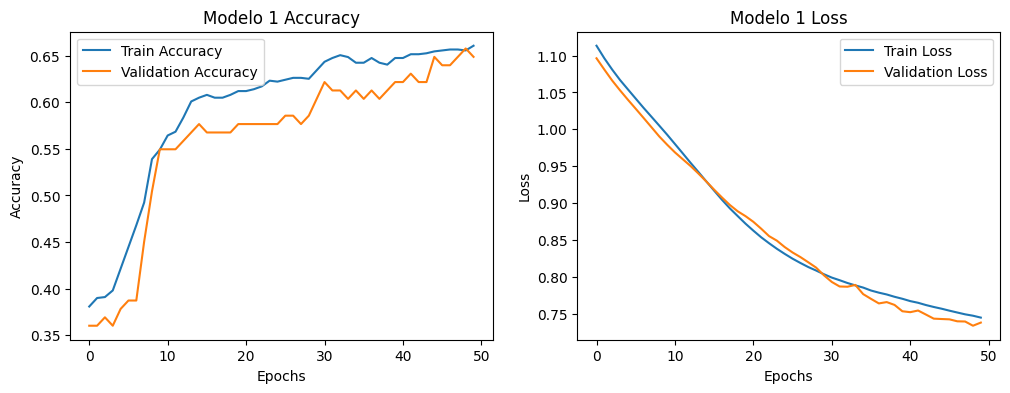

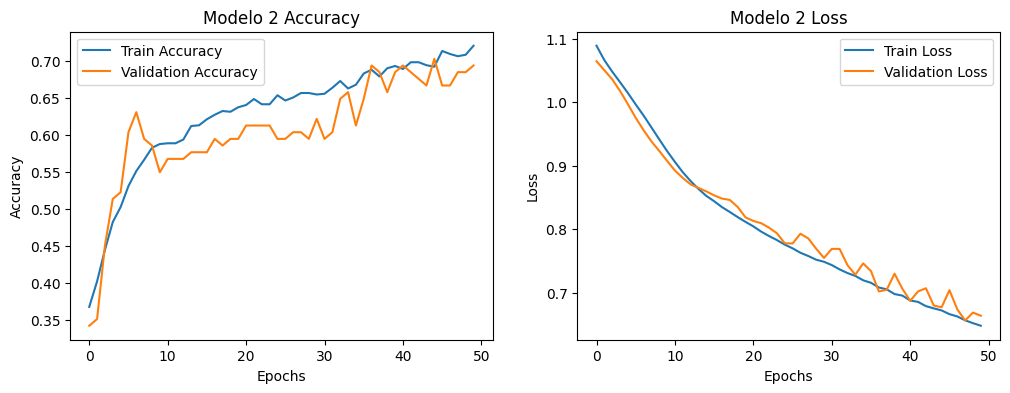

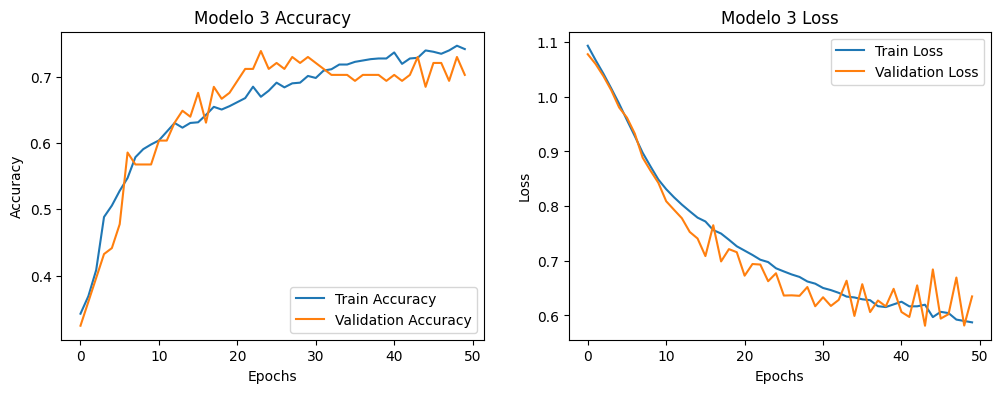

4/4 [==============================] - 0s 3ms/step


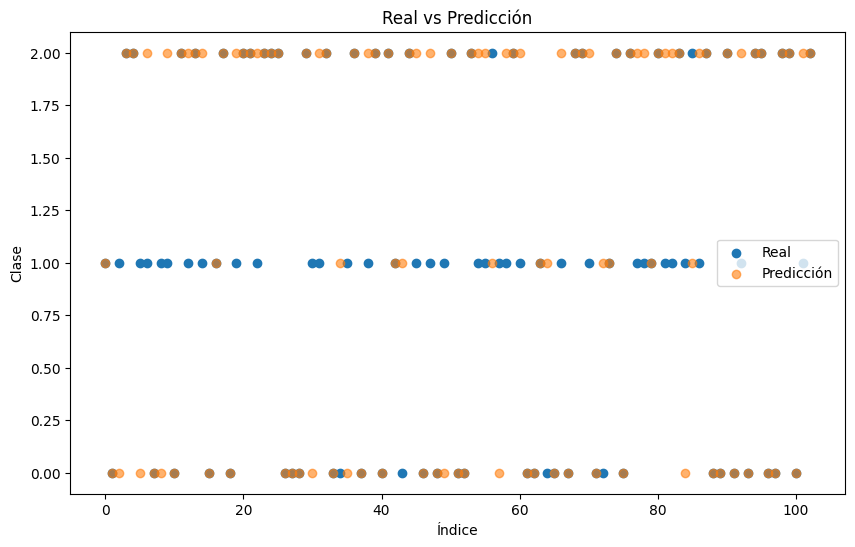

4/4 [==============================] - 0s 3ms/step


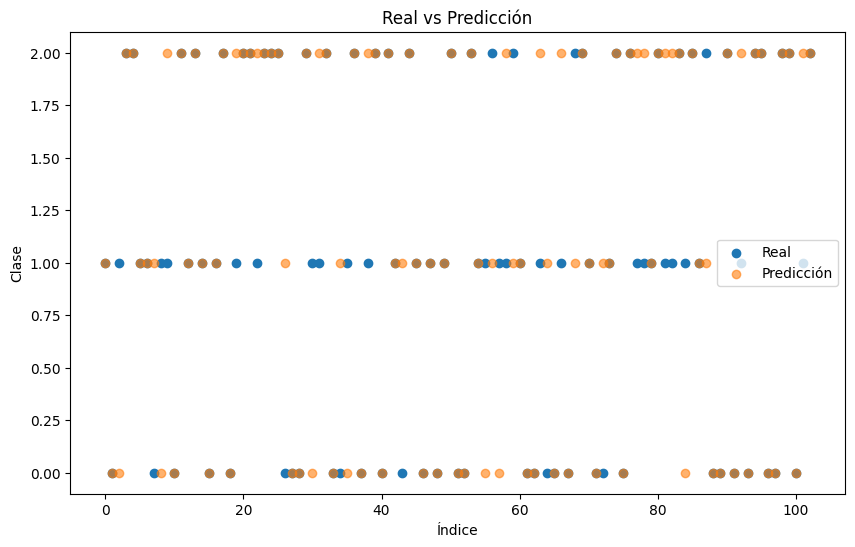

4/4 [==============================] - 0s 4ms/step


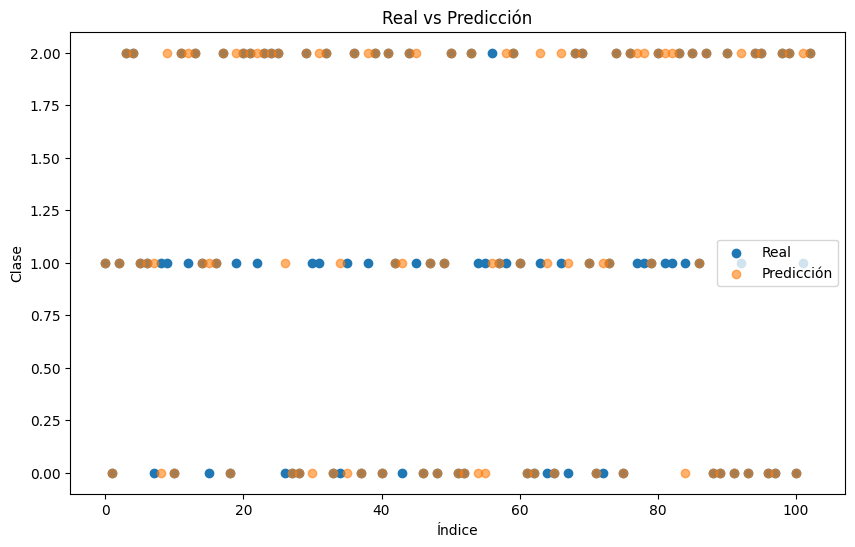

In [35]:
# Convierto las etiquetas a una representación categórica
y_train_categorical = to_categorical(y_train, num_classes=3)
y_val_categorical = to_categorical(y_val, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

print(y_train_categorical.shape, y_val_categorical.shape, y_test_categorical.shape)

# Tras hacer varias pruebas, me quedo con estos parámetros para acelerar el procesamiento
n_epochs = 50
batch_size = 512
lr = 0.001

# Voy a probar con 3 modelos diferentes a ver cuál es mejor
def create_model_1():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_normalized.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_2():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_normalized.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_3():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_normalized.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Entrenamos y evaluamos
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    return history

model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()

history_1 = train_and_evaluate_model(model_1, X_train_normalized, y_train_categorical, X_val_normalized, y_val_categorical, X_test_normalized, y_test_categorical)
history_2 = train_and_evaluate_model(model_2, X_train_normalized, y_train_categorical, X_val_normalized, y_val_categorical, X_test_normalized, y_test_categorical)
history_3 = train_and_evaluate_model(model_3, X_train_normalized, y_train_categorical, X_val_normalized, y_val_categorical, X_test_normalized, y_test_categorical)

# Resumen de los 3 modelos
print("Modelo 1:")
model_1.summary()

print("\nModelo 2:")
model_2.summary()

print("\nModelo 3:")
model_3.summary()


# Graficamos accuracy y loss
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{title} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{title} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

plot_history([history_1, history_2, history_3], ['Modelo 1', 'Modelo 2', 'Modelo 3'])

# Graficamos predicciones vs realidad
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, label='Real')
    plt.scatter(range(len(y_pred_classes)), y_pred_classes, label='Predicción', alpha=0.6)
    plt.title('Real vs Predicción')
    plt.xlabel('Índice')
    plt.ylabel('Clase')
    plt.legend()
    plt.show()

plot_predictions(model_1, X_test_normalized, y_test_categorical)
plot_predictions(model_2, X_test_normalized, y_test_categorical)
plot_predictions(model_3, X_test_normalized, y_test_categorical)

In [36]:
# Voy a ver las predicciones del mejor modelo que es el 2

predictions1D_train = model_2.predict(X_train_normalized, batch_size=batch_size)
predictions1D_val = model_2.predict(X_val_normalized, batch_size=batch_size)
predictions1D_test = model_2.predict(X_test_normalized, batch_size=batch_size)

print(classification_report(y_test_categorical.argmax(axis=1), predictions1D_test.argmax(axis=1)))

1/1 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.62      0.43      0.51        37
           2       0.68      0.88      0.77        34

    accuracy                           0.70       103
   macro avg       0.70      0.71      0.69       103
weighted avg       0.69      0.70      0.68       103



Trial 20 Complete [00h 00m 02s]
val_accuracy: 0.38738739490509033

Best val_accuracy So Far: 0.5765765905380249
Total elapsed time: 00h 00m 51s

Los mejores hiperparámetros son:
- Unidades en la capa de entrada: 32
- Activación en la capa de entrada: relu
- Número de capas ocultas: 1
- Tasa de aprendizaje: 0.0012180378893675472

Unidades en la capa 1: 480
Activación en la capa 1: relu
Epoch 1/50
2/2 [==============================] - 1s 186ms/step - loss: 1.0785 - accuracy: 0.4053 - val_loss: 1.0467 - val_accuracy: 0.5315
Epoch 2/50
2/2 [==============================] - 0s 33ms/step - loss: 1.0443 - accuracy: 0.5431 - val_loss: 1.0165 - val_accuracy: 0.5225
Epoch 3/50
2/2 [==============================] - 0s 30ms/step - loss: 1.0125 - accuracy: 0.5674 - val_loss: 0.9887 - val_accuracy: 0.5405
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.9829 - accuracy: 0.5724 - val_loss: 0.9611 - val_accuracy: 0.5676
Epoch 5/50
2/2 [==============================] - 0s 47

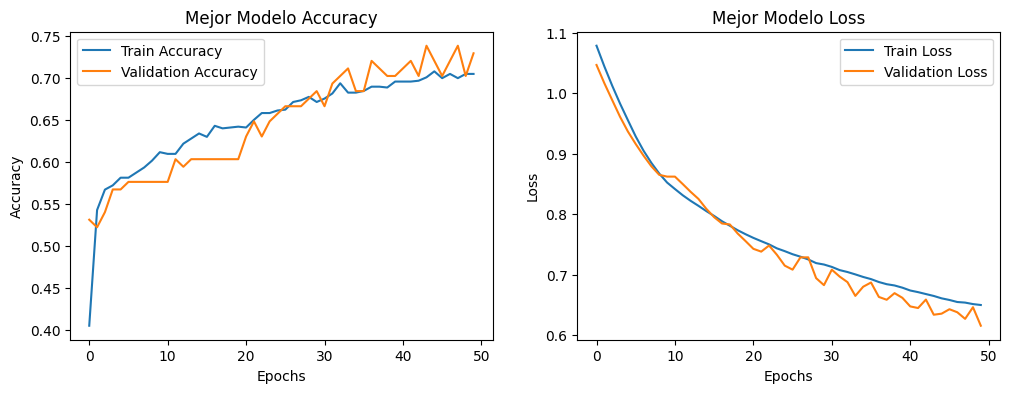

4/4 [==============================] - 0s 3ms/step


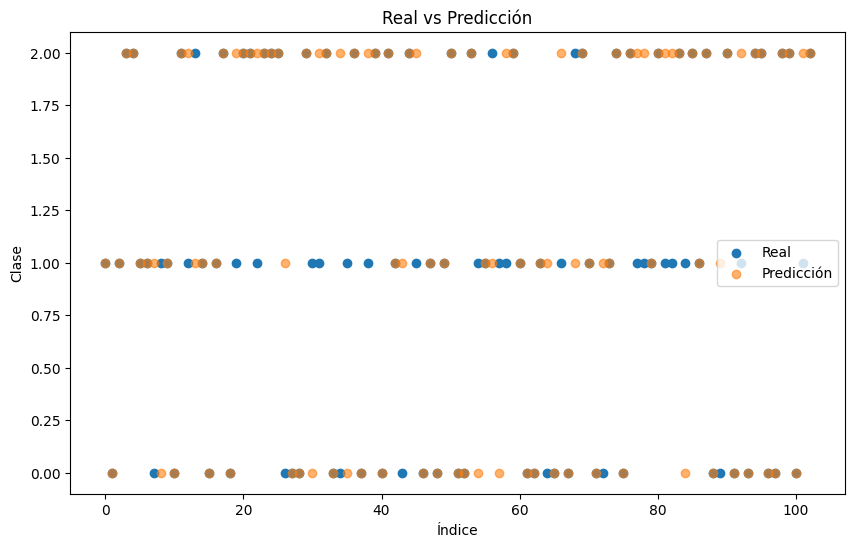

In [37]:
# Ahora vamos a probar con Keras Tuner para hacer un estudio de hiperparámetros, añadir stop early y ver la mejor combinación posible

# Defino el modelo para Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_input', values=['relu', 'tanh']),
        input_dim=X_train_normalized.shape[1]
    ))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh'])
        ))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Por motivos de gasto de recursos, voy a usar el método RandomSearch en vez de Hyperband, con el que empecé, debido a que en el segundo no puedo controlar
# el número de trials y tradaba muchísimo en ejecutar. El primer método no es tan preciso pero es mejor para ejecutar aquí la práctica.
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Número máximo de trials
    executions_per_trial=1,
    directory='random_search',
    project_name='price_classification',
    overwrite=True
)


# Paramos la búsqueda si no hay mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Búsqueda de hiperparámetros
tuner.search(
    X_train_normalized, y_train_categorical,
    validation_data=(X_val_normalized, y_val_categorical),
    callbacks=[stop_early],
    batch_size=batch_size
)

# Aquí obtengo los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Los mejores hiperparámetros son:
- Unidades en la capa de entrada: {best_hps.get('units_input')}
- Activación en la capa de entrada: {best_hps.get('activation_input')}
- Número de capas ocultas: {best_hps.get('num_layers')}
- Tasa de aprendizaje: {best_hps.get('learning_rate')}
""")

for i in range(best_hps.get('num_layers')):
    print(f"Unidades en la capa {i+1}: {best_hps.get(f'units_{i}')}")
    print(f"Activación en la capa {i+1}: {best_hps.get('activation')}")

# Entrenamos de nuevo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_normalized, y_train_categorical,
    epochs=n_epochs,
    validation_data=(X_val_normalized, y_val_categorical),
    batch_size=batch_size,
    callbacks=[stop_early]
)

# Evaluamos el mejor modelo en el conjunto de prueba
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

predictions1D_train_bm = best_model.predict(X_train_normalized, batch_size=batch_size)
predictions1D_val_bm = best_model.predict(X_val_normalized, batch_size=batch_size)
predictions1D_test_bm = best_model.predict(X_test_normalized, batch_size=batch_size)

print(classification_report(y_test_categorical.argmax(axis=1), predictions1D_test_bm.argmax(axis=1)))


# Graficamos
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history, 'Mejor Modelo')

# Graficamos predicciones vs realidad
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, label='Real')
    plt.scatter(range(len(y_pred_classes)), y_pred_classes, label='Predicción', alpha=0.6)
    plt.title('Real vs Predicción')
    plt.xlabel('Índice')
    plt.ylabel('Clase')
    plt.legend()
    plt.show()

plot_predictions(best_model, X_test_normalized, y_test_categorical)


Vemos como el estudio de los mejores hiperparámetros mejora ligeramente la predicción de nuestro modelo. De momento nos quedamos con este "predictions1D_train_bm" para la posterior comprobación de dimensiones con imágenes. Aunque también podríamos quedarnos con el modelo 1 que entrenamos antes.

In [38]:
# Vamos a hacer una última prueba. Voy a probar estos mejores hiper-parámetros haciendo cross-validation

best_hps = {
    'units_input': best_hps.get('units_input'),
    'num_layers': best_hps.get('num_layers'),
    'activation': best_hps.get('activation_input'),
    'learning_rate': best_hps.get('learning_rate'),
    'batch_size': batch_size,
    'epochs': n_epochs
}

# Defino el modelo utilizando los mejores hiperparámetros
def build_best_model(hps):
    model = Sequential()
    model.add(Dense(
        units=hps['units_input'],
        activation=hps['activation'],
        input_dim=X_train_normalized.shape[1]
    ))

    for i in range(hps['num_layers']):
        model.add(Dense(
            units=hps['units_input'],
            activation=hps['activation']
        ))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hps['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Defino KFold para validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_val_loss = []
cv_val_accuracy = []
cv_predictions = []
cv_true_labels = []

for train_index, val_index in kf.split(X_train_normalized):
    X_cv_train, X_cv_val = X_train_normalized[train_index], X_train_normalized[val_index]
    y_cv_train, y_cv_val = y_train_categorical[train_index], y_train_categorical[val_index]

    best_model_cv = build_best_model(best_hps)
    history = best_model_cv.fit(
        X_cv_train, y_cv_train,
        epochs=best_hps['epochs'],
        validation_data=(X_cv_val, y_cv_val),
        batch_size=best_hps['batch_size'],
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )

    # Evaluamos
    val_loss, val_accuracy = best_model_cv.evaluate(X_cv_val, y_cv_val)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')

    # Guardamos los resultados
    cv_val_loss.append(val_loss)
    cv_val_accuracy.append(val_accuracy)

    # Genero predicciones y guardo las etiquetas
    y_pred = best_model_cv.predict(X_cv_val, batch_size=batch_size)
    cv_predictions.append(y_pred)
    cv_true_labels.append(y_cv_val)

print(f'Mean cross-validation loss: {np.mean(cv_val_loss)}')
print(f'Standard deviation of cross-validation loss: {np.std(cv_val_loss)}')
print(f'Mean cross-validation accuracy: {np.mean(cv_val_accuracy)}')
print(f'Standard deviation of cross-validation accuracy: {np.std(cv_val_accuracy)}')

# Concatenamos todas las predicciones y etiquetas para su impresión
cv_predictions = np.concatenate(cv_predictions)
cv_true_labels = np.concatenate(cv_true_labels)

print(classification_report(cv_true_labels.argmax(axis=1), cv_predictions.argmax(axis=1)))




Epoch 1/50
2/2 [==============================] - 2s 285ms/step - loss: 1.0964 - accuracy: 0.3777 - val_loss: 1.0867 - val_accuracy: 0.3889
Epoch 2/50
2/2 [==============================] - 0s 59ms/step - loss: 1.0822 - accuracy: 0.3840 - val_loss: 1.0769 - val_accuracy: 0.3939
Epoch 3/50
2/2 [==============================] - 0s 57ms/step - loss: 1.0707 - accuracy: 0.4068 - val_loss: 1.0679 - val_accuracy: 0.4394
Epoch 4/50
2/2 [==============================] - 0s 42ms/step - loss: 1.0598 - accuracy: 0.4487 - val_loss: 1.0599 - val_accuracy: 0.4444
Epoch 5/50
2/2 [==============================] - 0s 49ms/step - loss: 1.0496 - accuracy: 0.4664 - val_loss: 1.0521 - val_accuracy: 0.4444
Epoch 6/50
2/2 [==============================] - 0s 45ms/step - loss: 1.0403 - accuracy: 0.4892 - val_loss: 1.0447 - val_accuracy: 0.4646
Epoch 7/50
2/2 [==============================] - 0s 49ms/step - loss: 1.0311 - accuracy: 0.5209 - val_loss: 1.0374 - val_accuracy: 0.4899
Epoch 8/50
2/2 [==========

Validation Loss: 0.8693448901176453
Validation Accuracy: 0.5634517669677734
1/1 [==============================] - 0s 50ms/step
Epoch 1/50
2/2 [==============================] - 1s 184ms/step - loss: 1.1607 - accuracy: 0.2228 - val_loss: 1.1518 - val_accuracy: 0.2030
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 1.1428 - accuracy: 0.2468 - val_loss: 1.1347 - val_accuracy: 0.2538
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 1.1275 - accuracy: 0.2582 - val_loss: 1.1205 - val_accuracy: 0.2690
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 1.1139 - accuracy: 0.3000 - val_loss: 1.1083 - val_accuracy: 0.3046
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 1.1015 - accuracy: 0.3304 - val_loss: 1.0971 - val_accuracy: 0.3553
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 1.0906 - accuracy: 0.3684 - val_loss: 1.0870 - val_accuracy: 0.3756
Epoch 7/50
2/2 [=====================

1/1 [==============================] - 0s 71ms/step
Mean cross-validation loss: 0.8075590968132019
Standard deviation of cross-validation loss: 0.04342418746698104
Mean cross-validation accuracy: 0.6230631113052368
Standard deviation of cross-validation accuracy: 0.035714233229930586
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       316
           1       0.54      0.33      0.41       345
           2       0.65      0.72      0.69       326

    accuracy                           0.62       987
   macro avg       0.61      0.63      0.61       987
weighted avg       0.61      0.62      0.60       987



Vemos que con esta última forma tampoco mejora mucho el modelo, por lo que podemos me quedo con el best_model que seleccionaba los mejores hiperparámetros.

# **CLASIFICACIÓN DE IMÁGENES**

In [39]:
# Código de la profesora
R = images[muestra_i,:,:,0]
G = images[muestra_i,:,:,1]
B = images[muestra_i,:,:,2]
rgb_muestra = np.stack([B, G, R], axis=2)

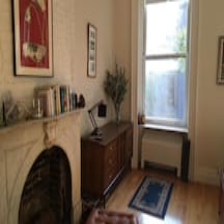

In [40]:
# Código de la profesora
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(rgb_muestra*255)
#print(images[muestra_i])

In [41]:
# Establezco los índices de train, val y test de los datos tabulares para replicarlo en las imágenes. De este modo, podemos usar las mismas clases de "y" también.

train_idx, val_idx, test_idx = data_train.index, data_val.index, data_test.index

X_train_img = images[train_idx, :,:,:]
X_val_img = images[val_idx, :,:,:]
X_test_img = images[test_idx, :,:,:]

# Shape imágenes
(X_train_img.shape, X_val_img.shape, X_test_img.shape)

((987, 224, 224, 3), (111, 224, 224, 3), (103, 224, 224, 3))

In [42]:
# Compruebo shape de datos tabulares y vemos que son iguales
(X_train_normalized.shape, X_val_normalized.shape, X_test_normalized.shape)

((987, 29), (111, 29), (103, 29))

**Modelo pre-entrenado: Transfer learning**

In [43]:
# He decidido usar el modelo pre-entrenado ResNet50 porque creo que es el mejor para el procesamiento de imágenes, con unas altas capacidades
# de aprendizaje de características, lo que ayuda a obtener un mejor rendimiento. Voy a congelar las capas iniciales y entrenar con las superiores

def create_2D_CNN(input_shape, n_classes=3, chanDim=3):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False
        print('Capa ' + layer.name + ' congelada.')

    last = base_model.output
    x = GlobalMaxPooling2D()(last)
    x = Dense(1024, activation='relu', kernel_constraint=max_norm(3.))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation='softmax', name='predictions')(x)

    model = Model(base_model.input, x)

    model.summary()

    return model

n_epochs = 10 # pongo pocas épocas para que no tarde tanto, aunque los resultados sean peores
batch_size = 512
lr = 0.001

# Creamos el modelo
model2D = create_2D_CNN((X_train_img.shape[1], X_train_img.shape[2], X_train_img.shape[3]), n_classes=3)

# Definimos callbacks
earlyStopping_callback = callbacks.EarlyStopping(
    monitor="val_loss", # pérdida del conjunto de validación
    min_delta=0.001,
    patience=5,
    restore_best_weights=True # restauramos los pesos al mejor estado observado
) # Esto pararará el entrenamiento si la métrica de validación no mejora tras un número de épocas (5)

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
) # Esto reduce la tasa de aprendizaje si una métrica deja de mejorar

checkpoints_saver = callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/keepcoding_DL/best_model_img.h5",
    monitor="val_loss",
    save_best_only=True, # solo guardamos el mejor modelo
    save_weights_only=False # se guarda todo el modelo
)

# Compilamos y entrenamos el modelo
model2D.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

H = model2D.fit(
    X_train_img, y_train_categorical,
    validation_data=(X_val_img, y_val_categorical),
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[earlyStopping_callback, reduce_lr_callback, checkpoints_saver]
)

# Guardo el modelo y veo su resumen
model2D.save("/content/drive/MyDrive/keepcoding_DL/resnet50_fine_tuned.h5")

model2D.summary()

predictions2D_train = model2D.predict(X_train_img, batch_size=batch_size)
predictions2D_val = model2D.predict(X_val_img, batch_size=batch_size)
predictions2D_test = model2D.predict(X_test_img, batch_size=batch_size)

print(classification_report(y_test_categorical.argmax(axis=1), predictions2D_test.argmax(axis=1)))

94765736/94765736 [==============================] - 3s 0us/step
Capa input_1 congelada.
Capa conv1_pad congelada.
Capa conv1_conv congelada.
Capa conv1_bn congelada.
Capa conv1_relu congelada.
Capa pool1_pad congelada.
Capa pool1_pool congelada.
Capa conv2_block1_1_conv congelada.
Capa conv2_block1_1_bn congelada.
Capa conv2_block1_1_relu congelada.
Capa conv2_block1_2_conv congelada.
Capa conv2_block1_2_bn congelada.
Capa conv2_block1_2_relu congelada.
Capa conv2_block1_0_conv congelada.
Capa conv2_block1_3_conv congelada.
Capa conv2_block1_0_bn congelada.
Capa conv2_block1_3_bn congelada.
Capa conv2_block1_add congelada.
Capa conv2_block1_out congelada.
Capa conv2_block2_1_conv congelada.
Capa conv2_block2_1_bn congelada.
Capa conv2_block2_1_relu congelada.
Capa conv2_block2_2_conv congelada.
Capa conv2_block2_2_bn congelada.
Capa conv2_block2_2_relu congelada.
Capa conv2_block2_3_conv congelada.
Capa conv2_block2_3_bn congelada.
Capa conv2_block2_add congelada.
Capa conv2_block2_ou

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 73s 42s/step - loss: 7.9780 - accuracy: 0.3161 - val_loss: 8.0755 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 4s 3s/step - loss: 7.3733 - accuracy: 0.3465 - val_loss: 1.1783 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 3.5655 - accuracy: 0.3475 - val_loss: 5.1305 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 4.8025 - accuracy: 0.3323 - val_loss: 3.1758 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 2.7466 - accuracy: 0.3313 - val_loss: 3.0155 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 3.4185 - accuracy: 0.3475 - val_loss: 2.3583 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 2.1330 - accuracy: 0.3546 - val_loss: 1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Evaluamos y mostramos las métricas
test_loss, test_accuracy = model2D.evaluate(X_test_img, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


4/4 [==============================] - 4s 482ms/step - loss: 1.1968 - accuracy: 0.3301
Test Loss: 1.1968201398849487
Test Accuracy: 0.3300970792770386


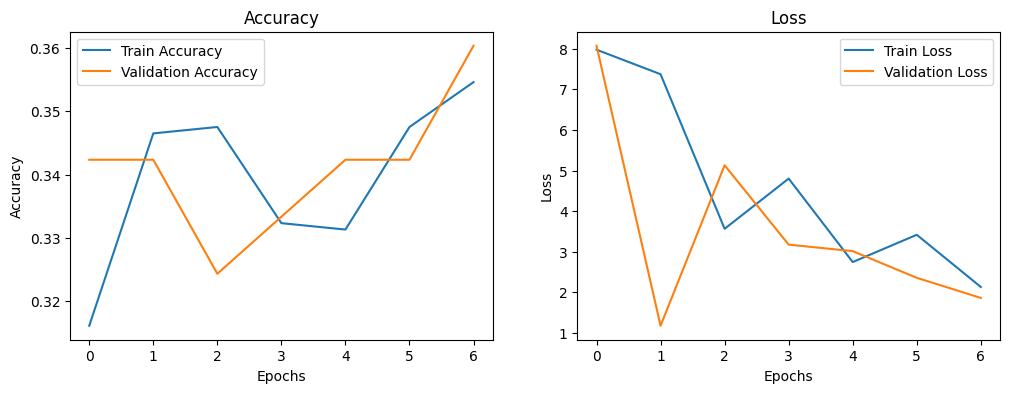

4/4 [==============================] - 0s 100ms/step


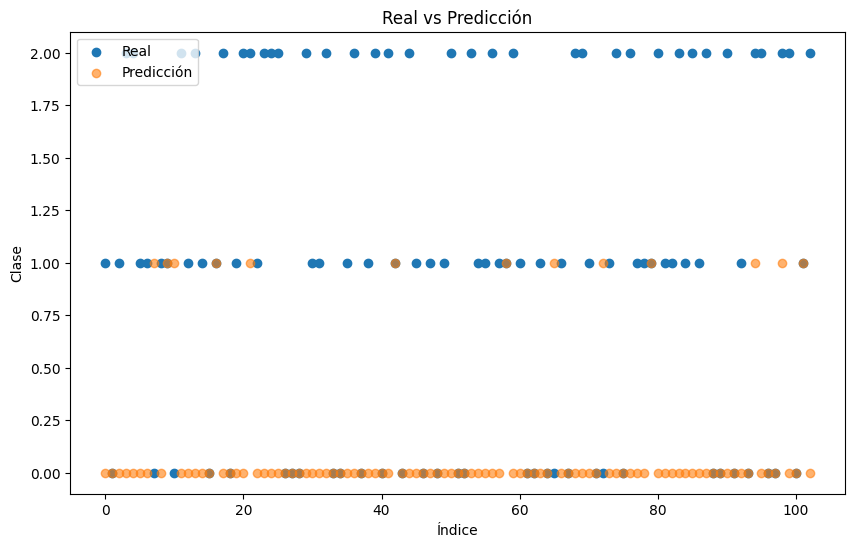

In [45]:
# Graficamos
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(H)

# Graficamos predicciones vs realidad
def plot_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, label='Real')
    plt.scatter(range(len(y_pred_classes)), y_pred_classes, label='Predicción', alpha=0.6)
    plt.title('Real vs Predicción')
    plt.xlabel('Índice')
    plt.ylabel('Clase')
    plt.legend()
    plt.show()

plot_predictions(model2D, X_test_img, y_test_categorical)


In [61]:
# Vemos que casi siempre predice una sola categoría. Esto no tiene mucho sentido, pero es que estamos entrenando con muy pocas épocas.
# Así que no vamos a fijarnos en el accuracy sino en ir probando distintas cosas.

Capa input_2 congelada.
Capa conv1_pad congelada.
Capa conv1_conv congelada.
Capa conv1_bn congelada.
Capa conv1_relu congelada.
Capa pool1_pad congelada.
Capa pool1_pool congelada.
Capa conv2_block1_1_conv congelada.
Capa conv2_block1_1_bn congelada.
Capa conv2_block1_1_relu congelada.
Capa conv2_block1_2_conv congelada.
Capa conv2_block1_2_bn congelada.
Capa conv2_block1_2_relu congelada.
Capa conv2_block1_0_conv congelada.
Capa conv2_block1_3_conv congelada.
Capa conv2_block1_0_bn congelada.
Capa conv2_block1_3_bn congelada.
Capa conv2_block1_add congelada.
Capa conv2_block1_out congelada.
Capa conv2_block2_1_conv congelada.
Capa conv2_block2_1_bn congelada.
Capa conv2_block2_1_relu congelada.
Capa conv2_block2_2_conv congelada.
Capa conv2_block2_2_bn congelada.
Capa conv2_block2_2_relu congelada.
Capa conv2_block2_3_conv congelada.
Capa conv2_block2_3_bn congelada.
Capa conv2_block2_add congelada.
Capa conv2_block2_out congelada.
Capa conv2_block3_1_conv congelada.
Capa conv2_block

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 42s 42s/step - loss: 2.2855 - accuracy: 0.3263 - val_loss: 13.7177 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 19s 19s/step - loss: 14.0792 - accuracy: 0.3262 - val_loss: 5.0210 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 22s 22s/step - loss: 5.4558 - accuracy: 0.3184 - val_loss: 6.3195 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 6.5239 - accuracy: 0.3284 - val_loss: 5.1666 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 16s 16s/step - loss: 5.5242 - accuracy: 0.3368 - val_loss: 6.8572 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 24s 24s/step - loss: 7.3315 - accuracy: 0.3032 - val_loss: 4.9560 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 14s 14s/step - loss: 5.1780 - accuracy: 0.3535 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        37
           2       0.33      1.00      0.50        34

    accuracy                           0.33       103
   macro avg       0.11      0.33      0.17       103
weighted avg       0.11      0.33      0.16       103

4/4 [==============================] - 0s 86ms/step - loss: 2.3120 - accuracy: 0.3301
Test Loss: 2.3119704723358154
Test Accuracy: 0.3300970792770386


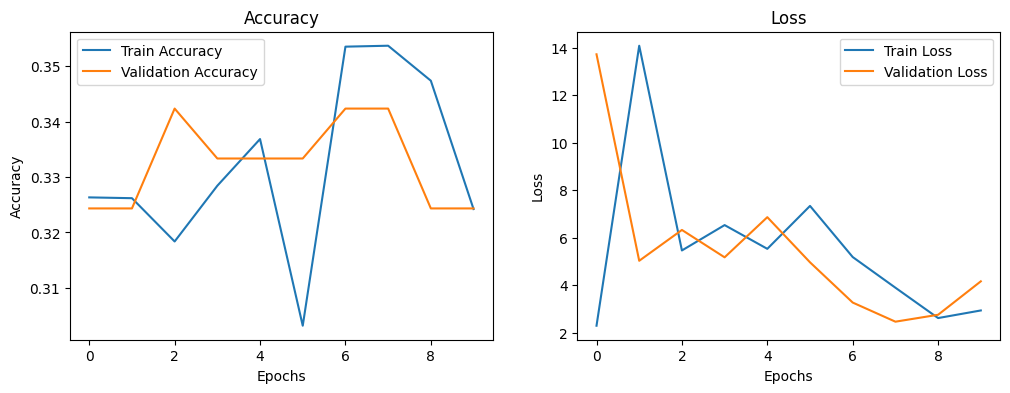

In [47]:
# Ahora vamos a probar con Data Augmentation para ver si lo mejoramos

train_steps_per_epoch = 1
val_steps_per_epoch = 1
test_steps_per_epoch = 1

# Creamos el modelo
model2D_DA = create_2D_CNN((X_train_img.shape[1], X_train_img.shape[2], X_train_img.shape[3]), n_classes=3)

# Definimos callbacks
earlyStopping_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

checkpoints_saver = callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/keepcoding_DL/best_model_img_DA.h5",
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='max'
)

# Compilamos y entrenamos
model2D_DA.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

# Usamos Data Augmentation para el conjunto de entrenamiento, validación y test
datagen_train = ImageDataGenerator(
    rescale=1.,
    rotation_range=40,  # Rotación aleatoria de las imágenes en el rango (grados, 0 a 180)
    width_shift_range=0.02,  # Desplazamiento horizontal aleatorio de las imágenes (fracción del ancho total)
    height_shift_range=0.02,  # Desplazamiento vertical aleatorio de las imágenes (fracción de la altura total)
    zoom_range=0.02,  # Zoom aleatorio
    preprocessing_function=imagenet_utils.preprocess_input,  # Preprocesamiento de imagen según ImageNet
    horizontal_flip=True  # Volteo horizontal aleatorio de las imágenes
)

datagen_train.fit(X_train_img)

# Creamos los generadores sin augmentation
datagen_val = ImageDataGenerator(preprocessing_function=imagenet_utils.preprocess_input)
datagen_val.fit(X_val_img)
datagen_test = ImageDataGenerator(preprocessing_function=imagenet_utils.preprocess_input)
datagen_test.fit(X_test_img)


H = model2D_DA.fit(datagen_train.flow(X_train_img, y_train_categorical, batch_size=batch_size),
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=n_epochs,
                    validation_data=datagen_val.flow(X_val_img, y_val_categorical, batch_size=batch_size),
                    validation_steps=test_steps_per_epoch,
                    workers=8, callbacks=[earlyStopping_callback, reduce_lr_callback, checkpoints_saver])

predictions2D_train_da = model2D_DA.predict(X_train_img, batch_size=batch_size)
predictions2D_val_da = model2D_DA.predict(X_val_img, batch_size=batch_size)
predictions2D_test_da = model2D_DA.predict(X_test_img, batch_size=batch_size)

print(classification_report(y_test_categorical.argmax(axis=1), predictions2D_test_da.argmax(axis=1)))

# Evaluamos y mostramos métricas
test_loss, test_accuracy = model2D_DA.evaluate(X_test_img, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Graficamos
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(H)



Para las imágenes me quedo con el mejor modelo que nos da antes de data augmentation, es decir, "predictions2D_train" y compararé estas predicciones con las predicciones de los tabulares más adelante. Imagino que es normal que no mejore porque estamos probando (por límite de tiempo y recursos) con muy pocas épocas. Por lo que no es representativo. Pero dejo por aquí cómo se haría.

In [48]:
# Cargamos el mejor modelo

best_model_path = '/content/drive/MyDrive/keepcoding_DL/best_model_img.h5'
loaded_model = keras.models.load_model(best_model_path)
loaded_model.load_weights(best_model_path)

In [49]:
# Re-evaluamos el modelo en test y comprobamos los resultados

test_loss, test_accuracy = loaded_model.evaluate(X_test_img, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

4/4 [==============================] - 2s 88ms/step - loss: 1.1968 - accuracy: 0.3301
Test Loss: 1.1968201398849487
Test Accuracy: 0.3300970792770386


# **LATE FUSION**

In [50]:
# Comprobamos predicciones de datos tabulares (1D) con datos de imágenes (2D). Ambos representan los finales, es decir, las predicciones de los mejores modelos con los que nos hemos quedado

(predictions1D_train_bm.shape, predictions2D_train.shape)

((987, 3), (987, 3))

In [51]:
# Concatenamos las predicciones de datos tabulares con el best_model con las predicciones de imágenes con el primer modelo sin data augmentation

late_fusion_features_train = np.concatenate((predictions1D_train_bm, predictions2D_train), axis=1)
late_fusion_features_val = np.concatenate((predictions1D_val_bm, predictions2D_val), axis=1)
late_fusion_features_test = np.concatenate((predictions1D_test_bm, predictions2D_test), axis=1)
print(late_fusion_features_train.shape)
print(late_fusion_features_val.shape)
print(late_fusion_features_test.shape)

(987, 6)
(111, 6)
(103, 6)


(1098,)
(103,)
(1098, 6)
[[25  6  1]
 [ 6 16 15]
 [ 0  2 32]]
Late fusion accuracy: 0.7087378640776699 


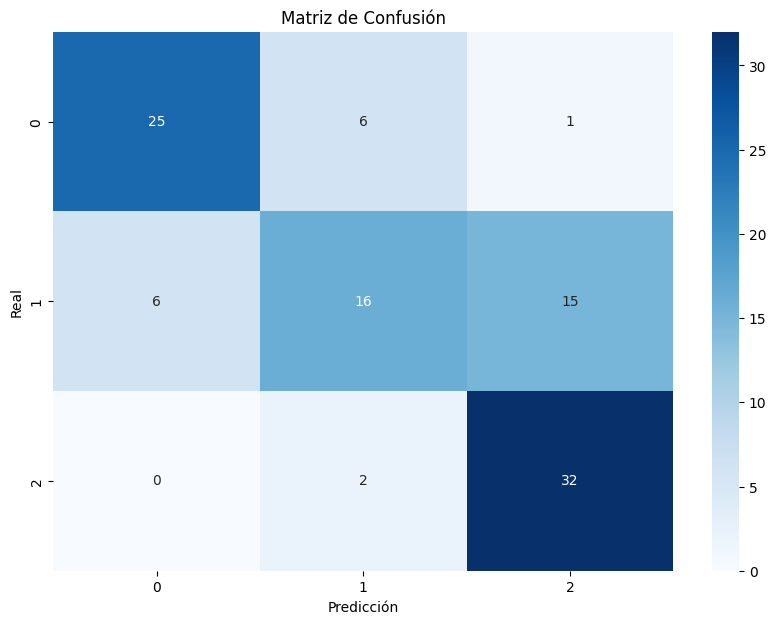

In [52]:
late_fusion_model = svm.SVC()
# SVM no acepta one-hot encoding, por lo tanto recuperamos las etiquetas normales:
y_train_new = y_train_categorical.argmax(axis=1)
y_val_new = y_val_categorical.argmax(axis=1)
y_train_val_new = np.concatenate((y_train_new,y_val_new))
print(y_train_val_new.shape) # Comprobamos las dimensiones de todas nuestras muestras para ver que todo está correcto y tiene sentido

y_test_new = y_test_categorical.argmax(axis=1)
print(y_test_new.shape)

X_late_fusion_features_train_val = np.concatenate((late_fusion_features_train,late_fusion_features_val)) # Concatenamos train y val de tabulares e imágenes
print(X_late_fusion_features_train_val.shape)

late_fusion_model.fit(X_late_fusion_features_train_val, y_train_val_new)

y_pred_train = late_fusion_model.predict(late_fusion_features_train)
y_pred_val = late_fusion_model.predict(late_fusion_features_val)
y_pred_test = late_fusion_model.predict(late_fusion_features_test)

cm = confusion_matrix(y_test_new, y_pred_test)
print(cm) # Imrpimo la matriz de confusión

accuracy_late_fusion = late_fusion_model.score(late_fusion_features_test, y_test_new)
print(f"Late fusion accuracy: {accuracy_late_fusion} ") # Vemos el accuracy de late fusion

# Grafico la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


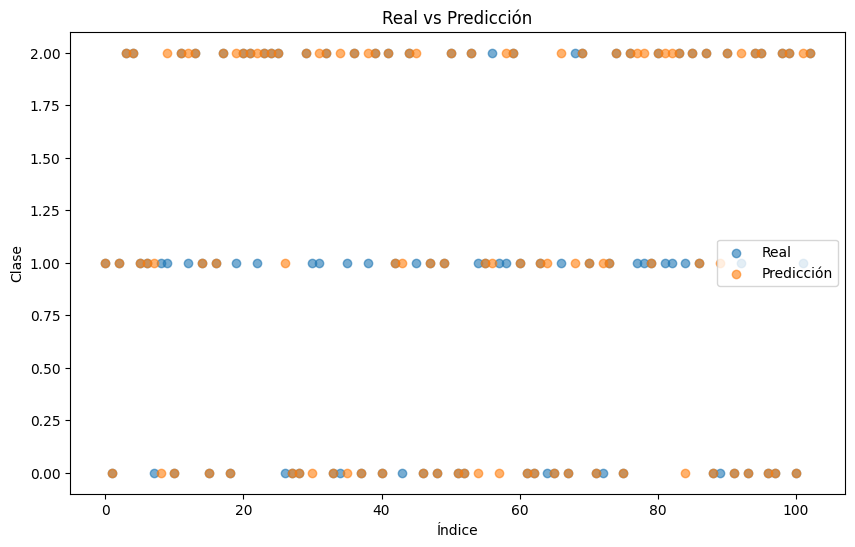

In [53]:
# Grafico predicciones vs realidad
def plot_predictions(true_labels, predictions):
    if len(true_labels.shape) == 1:  # Si los true_labels son unidimensionales
        true_classes = true_labels
    else:
        true_classes = np.argmax(true_labels, axis=1)

    if len(predictions.shape) == 1:  # Si las predicciones son unidimensionales
        pred_classes = predictions
    else:
        pred_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(true_classes)), true_classes, label='Real', alpha=0.6)
    plt.scatter(range(len(pred_classes)), pred_classes, label='Predicción', alpha=0.6)
    plt.title('Real vs Predicción')
    plt.xlabel('Índice')
    plt.ylabel('Clase')
    plt.legend()
    plt.show()

plot_predictions(y_test_new, y_pred_test)


# **EARLY FUSION**

In [54]:
# Datos tabulares

early_fusion1D_train_val = np.concatenate((X_train_normalized,X_val_normalized), axis=0)
early_fusion1D_train_val.shape

(1098, 29)

In [55]:
# Creamos el modelo ResNet50 preentrenado y preprocesamos las imágenes
classifier2D = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last_conv = classifier2D.layers[-3].output
last_conv_globalAvg = GlobalAveragePooling2D()(last_conv) # Para reducir la dimensionalidad y obtener un vector de características más manejable
feature_extractor = Model(classifier2D.input, last_conv_globalAvg)

feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [56]:
# Sacamos las características de train, val y test de las imágenes
early_fusion2D_train_img = feature_extractor.predict(X_train_img)
early_fusion2D_val_img = feature_extractor.predict(X_val_img)
early_fusion2D_test_img = feature_extractor.predict(X_test_img)

print(early_fusion2D_train_img.shape)
print(early_fusion2D_train_img.shape)
print(early_fusion2D_train_img.shape)

4/4 [==============================] - 0s 80ms/step
(987, 2048)
(987, 2048)
(987, 2048)


In [57]:
# Seguimos teniendo demasiadas variables, por lo que creo que tenemos que hacer reducción de la dimensionalidad con PCA.
# Voy a poner el mismo número de componentes que en los datos tabulares.

pca = PCA(n_components=29, random_state=42)
early_fusion2D_train_pca = pca.fit_transform(early_fusion2D_train_img)
early_fusion2D_val_pca = pca.transform(early_fusion2D_val_img)
early_fusion2D_test_pca = pca.transform(early_fusion2D_test_img)

print(early_fusion2D_train_pca.shape)
print(early_fusion2D_val_pca.shape)
print(early_fusion2D_test_pca.shape)

# Comprobamos que las dimensiones salen igual en comparación con nuestros datos tabulares.

(987, 29)
(111, 29)
(103, 29)


In [58]:
# Concateno tabulares con imágenes (teniendo en cuenta también que tengo que unir train con val)
early_fusion_features_train_val = np.concatenate((early_fusion1D_train_val, np.concatenate((early_fusion2D_train_pca,early_fusion2D_val_pca))), axis=1)
early_fusion_features_test = np.concatenate((X_test_normalized, early_fusion2D_test_pca), axis=1)
print(early_fusion_features_train_val.shape)
print(early_fusion_features_test.shape)
print(y_train_val_new.shape)
print(y_test_new.shape)

(1098, 58)
(103, 58)
(1098,)
(103,)


[[28  3  1]
 [11 11 15]
 [ 1  3 30]]
Early fusion accuracy: 0.6699029126213593 


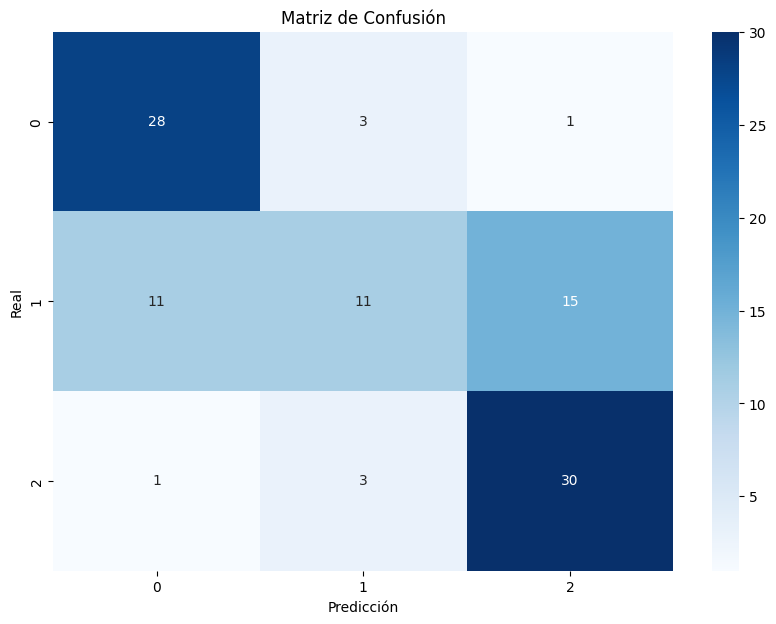

In [59]:
early_fusion_model = svm.SVC()
early_fusion_model.fit(early_fusion_features_train_val, y_train_val_new)

y_pred_test = early_fusion_model.predict(early_fusion_features_test)

cm = confusion_matrix(y_test_new, y_pred_test)
print(cm) # Imprimo matriz de confusión

accuracy_early_fusion = early_fusion_model.score(early_fusion_features_test, y_test_new)
print(f"Early fusion accuracy: {accuracy_early_fusion} ") # Veo el accuracy de early fusion

# Grafico la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [62]:
# Finalmente, Late fusion es el que me da mejores resultados de accuracy.